## Faltung ##

Dieses Notebook demonstriert die Faltung interaktiv
$$
y[n] = x[n] \ast h[n] = \sum_{i = -\infty}^{+\infty} x[i] h[n-i]
$$

In [94]:
%matplotlib inline
# "inline" renders using inline png graphics
from __future__ import print_function, division
import sys
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
from matplotlib import animation
from IPython.display import HTML
from IPython import __version__ as ipy_version

sys.path.append('../..')
from dsp_fpga_lib import versions
versions()
print("IPython:", ipy_version)

plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams["animation.html"] = "jshtml"  # for matplotlib 2.1 and above, uses JavaScript
#plt.rcParams["animation.html"] = "html5" # for matplotlib 2.0 and below, converts to x264 using ffmpeg video codec

Python version: 3.6.3
Numpy: 1.13.3
Scipy: 0.19.1
Matplotlib: 2.1.0 module://ipykernel.pylab.backend_inline
IPython: 5.3.0


In [98]:
# define signal and impulse response here
h = [1, 1, 1, 1, 1] # impulse response
x = [1, -1] # input signal
len_h = len(h)
len_x = len(x) # length of input signal

y = np.convolve(x, h)
L = len(y) + 3

# create arrays with same length for plotting
n = np.arange(L)
xp = np.append(x, np.zeros(L - len_x)) # fill up with zeros 
hp = np.append(h, np.zeros(L - len_h)) # for total length of L
yp = np.append(y, np.zeros(L - len(y))) # 

# create zero padded copy of x for animation plotting
x_i = np.pad(x, (L+5, L+1), 'constant', constant_values=(0,0))

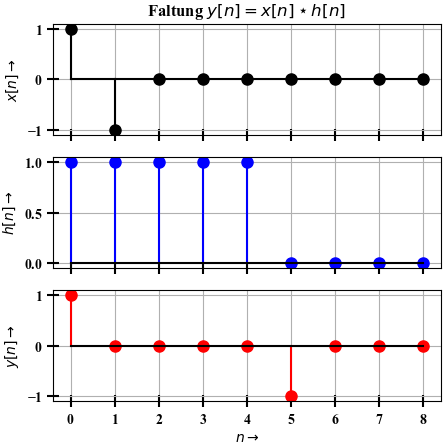

In [99]:
# First set up the figure, the axis, and the plot element(s) we want to animate. %%caption suppresses blank window
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)
ml0, sl0, bl0 = ax[0].stem(n, xp, 'k-', 'ko', 'k') # input signal
ml1, sl1, bl1 = ax[1].stem(n, hp, 'b-', 'bo', 'k') # impulse response
ml2, sl2, bl2 = ax[2].stem(n, yp, 'r-', 'ro', 'k') # output signal

ax[0].grid(True)
ax[0].set_ylabel(r'$x[n] \rightarrow$')
ax[0].set_title(r'Faltung $y[n] = x[n] \star h[n]$')
ax[1].set_ylabel(r'$h[n] \rightarrow$')
ax[2].set_ylabel(r'$y[n] \rightarrow$')
ax[2].set_xlabel(r'$n \rightarrow$');

In [97]:
def animate(i):
    print(i, end='')
    #x_i = x[len_x + i:]
    ax[0].cla()
    ml0, sl0, bl0 = ax[0].stem(n[:L], x_i[-L-1-i:-1-i], 'k-', 'ko', 'k') # x[-2] is second element from the end
    ax[0].set_ylabel(r'$x[n] \rightarrow$');
    ax[0].set_ylim((-1.5, 1.5))
    y_i = np.convolve(x_i[-L-1-i:-1-i], h)[:L]
    ax[2].cla()
    ml2, sl2, bl2 = ax[2].stem(n[:L], y_i, 'r-', 'ro', 'k')
    ax[2].set_ylim((-1.5, 1.5))
    #ax[2].set_xlabel(r'$n \rightarrow$')
    ax[2].set_ylabel(r'$y[n] \rightarrow$');

ani = animation.FuncAnimation(fig, animate, frames=L)
ani

0012345678